Using device: cpu
Iteration 2000/10000, Loss: 3054.385498
Iteration 4000/10000, Loss: 178.339066
Iteration 6000/10000, Loss: 22.504026
Iteration 8000/10000, Loss: 6.933119
Iteration 10000/10000, Loss: 1.089302


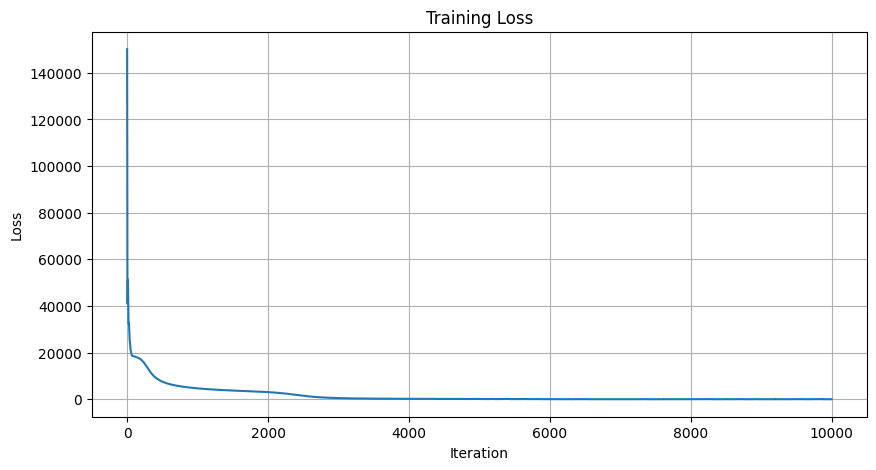

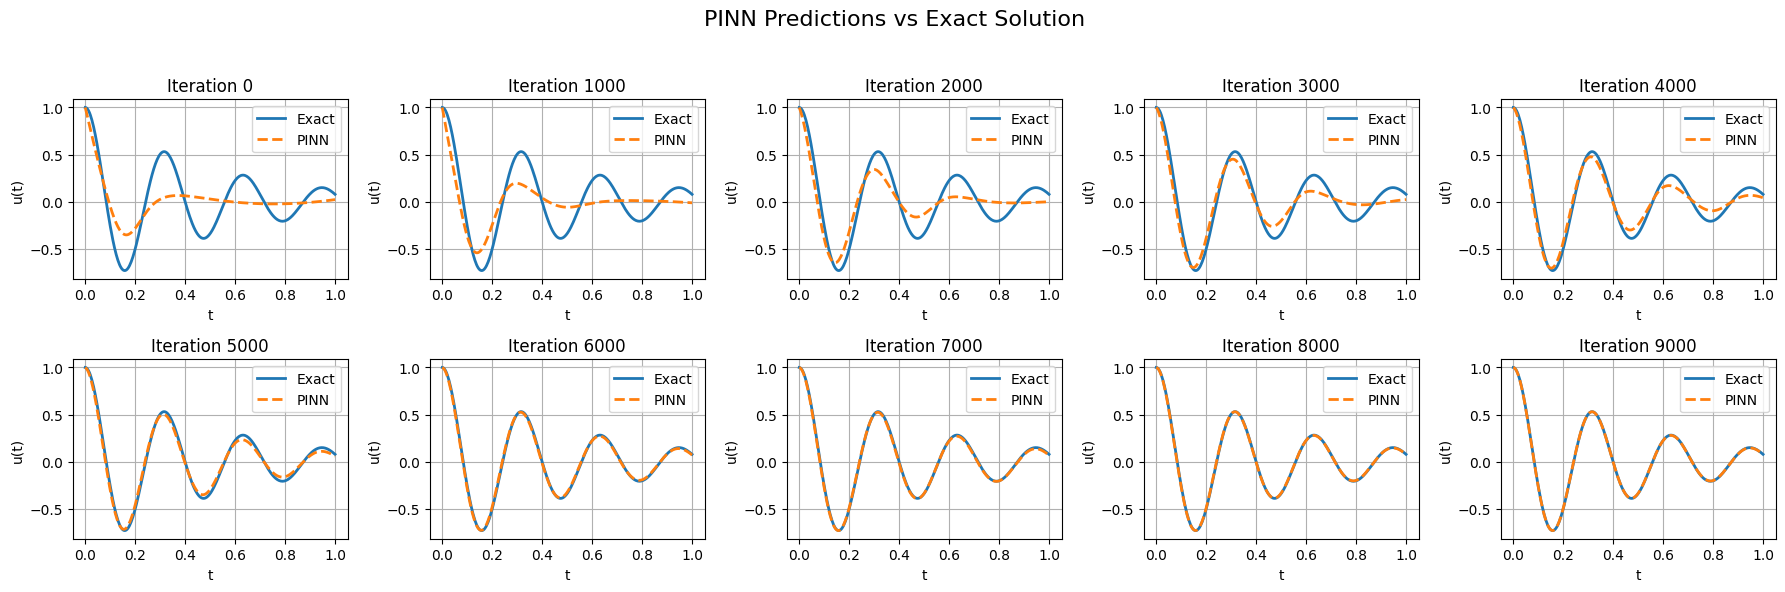

In [1]:
# =====================================================
# Physics-Informed Neural Network (PINN) for Damped Harmonic Oscillator
# =====================================================

import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# =====================================================
# Device configuration
# =====================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =====================================================
# Exact analytical solution (underdamped)
# =====================================================
def exact_solution(delta, omega0, t):
    """Compute the exact solution for underdamped harmonic oscillator."""
    assert delta < omega0, "System must be underdamped"
    omega = torch.sqrt(omega0**2 - delta**2)
    phi = torch.arctan(-delta / omega0)
    A = 1 / (2 * torch.cos(phi))
    return torch.exp(-delta * t) * 2 * A * torch.cos(phi + omega * t)

# =====================================================
# Neural Network architecture
# =====================================================
class PINN(nn.Module):
    """Physics-Informed Neural Network for 1D regression."""
    def __init__(self, input_size=1, hidden_size=100, output_size=1, num_hidden_layers=1):
        super(PINN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Tanh()]
        for _ in range(num_hidden_layers):
            layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """Enforce boundary condition u(0) = 1 via transformation."""
        return 1 + x * self.model(x)

# =====================================================
# Physics-informed loss function
# =====================================================
def pinn_loss(u0, dudt0, u, dudt, ddudtt, m, mu, k, weight_bc=10.0):
    """
    Compute combined PINN loss:
    - Boundary condition
    - ODE residual
    """
    # Boundary loss
    loss_bc = weight_bc * (u0 - 1)**2 + (dudt0)**2
    # PDE residual loss
    residual = m * ddudtt + mu * dudt + k * u
    loss_pde = (residual**2).mean()
    return loss_bc + loss_pde

# =====================================================
# Problem setup
# =====================================================
# System parameters
delta_val = 2.0
omega0_val = 20.0
mu_val = 4.0
k_val = omega0_val**2  # m = 1

delta = torch.tensor(delta_val, dtype=torch.float32, device=device)
omega0 = torch.tensor(omega0_val, dtype=torch.float32, device=device)

# Training and evaluation domains
t = torch.linspace(0, 1, 300, device=device).view(-1, 1)
t_train = torch.linspace(0, 1, 200, device=device, requires_grad=True).view(-1, 1)
t_boundary = torch.tensor([0.0], device=device, requires_grad=True)

# Exact solution for comparison
u_exact = exact_solution(delta, omega0, t.squeeze())

# =====================================================
# Model, optimizer, and training parameters
# =====================================================
model = PINN(input_size=1, hidden_size=100, num_hidden_layers=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_iterations = 10000

loss_history = []
snapshot_interval = 1000
u_snapshots = []

# =====================================================
# Training loop
# =====================================================
for iteration in range(1, num_iterations + 1):
    # Forward pass
    u = model(t_train)
    u0 = model(t_boundary)

    # Store snapshots for visualization
    if iteration % snapshot_interval == 0:
        u_snapshots.append(model(t).detach().cpu())

    # Compute derivatives
    dudt = torch.autograd.grad(u, t_train, torch.ones_like(u), create_graph=True)[0]
    ddudtt = torch.autograd.grad(dudt, t_train, torch.ones_like(dudt), create_graph=True)[0]
    dudt0 = torch.autograd.grad(u0, t_boundary, torch.ones_like(u0), create_graph=True)[0]

    # Compute loss
    loss = pinn_loss(u0, dudt0, u, dudt, ddudtt, m=1.0, mu=mu_val, k=k_val)
    loss_history.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Optional: print progress
    if iteration % 2000 == 0:
        print(f"Iteration {iteration}/{num_iterations}, Loss: {loss.item():.6f}")

# =====================================================
# Plot training loss
# =====================================================
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

# =====================================================
# Compare PINN vs Exact solution
# =====================================================
t_cpu = t.detach().cpu()
u_exact_cpu = u_exact.detach().cpu()

num_snapshots = len(u_snapshots)
cols = 5
rows = (num_snapshots + cols - 1) // cols

plt.figure(figsize=(18, 6))
for i, u_pred in enumerate(u_snapshots):
    plt.subplot(rows, cols, i + 1)
    plt.plot(t_cpu, u_exact_cpu, label="Exact", linewidth=2)
    plt.plot(t_cpu, u_pred, '--', label="PINN", linewidth=2)
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.title(f"Iteration {i * snapshot_interval}")
    plt.legend()
    plt.grid(True)

plt.suptitle("PINN Predictions vs Exact Solution", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
